In [46]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
import json
import os
import pandas as pd
import argparse
import matplotlib.pyplot as plt

class CustomEncoder(json.JSONEncoder):
    def encode(self, obj):
        result = super().encode(obj)
        result = result.replace('[\n            ', '[').replace('\n        ]', ']').replace('\n            ', ' ')
        return result

def load_json(filename):
    """加载json文件"""
    with open(filename, 'r', encoding='utf-8') as file:
        return json.load(file)

def save_json(filename, data):
    """保存json文件"""
    temp = json.dumps(data, cls=CustomEncoder, ensure_ascii=False, indent=4)
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(temp)

def filter_AC_data(input_files):
    """过滤AC条目"""
    data = [load_json(file) for file in input_files]

    temp_data_id_sets = []
    for d in data[:-1]:
        temp_data_id_sets.append({entry['submission1_id'] for entry in d if entry.get('code_test_score') == entry.get('TotalScore') and entry.get('TotalScore') != 0})

    valid_id = set.intersection(*temp_data_id_sets)

    #-----------------------------------------------
    print("The AC code contains", len(valid_id))
    #-----------------------------------------------

    filtered_data = []
    for d in data:
        filtered_data.append([entry for entry in d if entry.get('submission1_id') in valid_id])

    return filtered_data

def filter_innovate_data(input_files):
    """过滤改进条目"""
    data = [load_json(file) for file in input_files]

    file1_data, file2_data, file3_data = data

    file1_status = {entry['submission1_id']: entry['code_test_status'] for entry in file1_data}
    file2_status = {entry['submission1_id']: entry['code_test_status'] for entry in file2_data}
    file3_status = {entry['submission1_id']: entry['code1_test_status'] for entry in file3_data}

    valid_ids_file1 = set()
    valid_ids_file2 = set()

    for submission_id, status_file1 in file1_status.items():
        if submission_id in file3_status:
            status_file3 = file3_status[submission_id]
            if len(status_file1) == len(status_file3):
                flag = False
                for i in range(len(status_file3)):
                    if status_file3[i] == 1 and status_file1[i] == 0:
                        flag = False
                        break
                    elif status_file3[i] == 0 and status_file1[i] == 1:
                        flag = True
                if flag:
                    valid_ids_file1.add(submission_id)  

    for submission_id, status_file2 in file2_status.items():
        if submission_id in file3_status:
            status_file3 = file3_status[submission_id]
            if len(status_file2) == len(status_file3):
                flag = False
                for i in range(len(status_file3)):
                    if status_file3[i] == 1 and status_file2[i] == 0:
                        flag = False
                        break
                    elif status_file3[i] == 0 and status_file2[i] == 1:
                        flag = True
                if flag:
                    valid_ids_file2.add(submission_id)

    final_valid_ids = valid_ids_file1.intersection(valid_ids_file2)

    #------------------------------------------------------
    print("The innovative IDs length are:", len(final_valid_ids))
    #------------------------------------------------------
    
    filtered_data = []
    filtered_data.append([entry for entry in file1_data if entry['submission1_id'] in final_valid_ids])
    filtered_data.append([entry for entry in file2_data if entry['submission1_id'] in final_valid_ids])
    filtered_data.append([entry for entry in file3_data if entry['submission1_id'] in final_valid_ids])

    return filtered_data
# 过滤flag=False
def filter_data_by_flag(input_files):
    false_flags_ids = set()
    
    # 从第一个文件中提取flag为False的submission1_id
    with open(input_files[0], 'r', encoding='utf-8') as f:
        data = json.load(f)
        for item in data:
            if not item.get('flag', True):  # 默认flag为True，如果不存在则视为True
                false_flags_ids.add(item.get('submission1_id'))
    
    # 过滤其他文件中的相同submission1_id
    filtered_data = []
    for input_file in input_files:
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            filtered_data.append([
                item for item in data if item.get('submission1_id') not in false_flags_ids
            ])
    
    return filtered_data

def calculate_metrics(input_files, output_file, mode="1"):
    if mode == "2":
        filtered_data = filter_AC_data(input_files)
        output_file = output_file.replace('.csv', '_filtered_AC.csv')
    elif mode == "3":
        filtered_data = filter_innovate_data(input_files)
        output_file = output_file.replace('.csv', '_filtered_innovate.csv')
    else:
        filtered_data = []
        for input_file in input_files:
            with open(input_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                filtered_data.append(data)

    # 去掉人类的
    filtered_data = filtered_data[:-1]

    else_data = {entry['submission1_id']:entry for entry in filtered_data[0]} 
    our_data = {entry['submission1_id']:entry for entry in filtered_data[1]}

    our_Add_count = 0
    else_Add_count = 0
    our_RE_count = 0
    else_RE_count = 0
    for key, entry in our_data.items():
        if key in else_data:
            entry['overall_rate'] = (entry['code1_lines'] - entry['removed_lines'])/(entry['code1_lines'] + entry['added_lines'] - entry['removed_lines'])
            else_entry = else_data[key]
            else_entry['overall_rate'] = (else_entry['code1_lines'] - else_entry['removed_lines'])/(else_entry['code1_lines'] + else_entry['added_lines'] - else_entry['removed_lines'])
            if entry['added_lines'] < else_entry['added_lines']:
                our_Add_count += 1
            elif entry['added_lines'] > else_entry['added_lines']:
                else_Add_count += 1
            if entry['overall_rate'] > else_entry['overall_rate']:
                our_RE_count += 1
            elif entry['overall_rate'] < else_entry['overall_rate']:
                else_RE_count += 1
    results = []
    results.append({
        'our_AD': our_Add_count,
        'else_AD':else_Add_count,
        'our_RE':our_RE_count,
        'else_RE':else_RE_count
    })
    
    df = pd.DataFrame(results)
    # df.to_csv(output_file, index=False)
    # print(f"Results saved to {output_file}")
    print(df)
    return df

In [79]:
input_file1 = "last-gpt-4o-check_version.json"
input_file2 = "twostage_llama2gpt4o.json"
input_file3 = "people_with_retention_rate.json"
input_files = [input_file1, input_file2, input_file3]
mode = "1"
output_file = f"result/{mode}_result.csv"
df1 = calculate_metrics(input_files, output_file, mode)
input_file1 = "lora.json"
input_file2 = "Exec_test-checkpoint-250.json"
input_file3 = "people_with_retention_rate.json"
input_files = [input_file1, input_file2, input_file3]
# output_file = f"result/{mode}_result.csv"
df2 = calculate_metrics(input_files, output_file, mode)

Results saved to result/1_result.csv
   our_AD  else_AD  our_RE  else_RE
0    1283      174    1265      124
Results saved to result/1_result.csv
   our_AD  else_AD  our_RE  else_RE
0     267      291     276      304


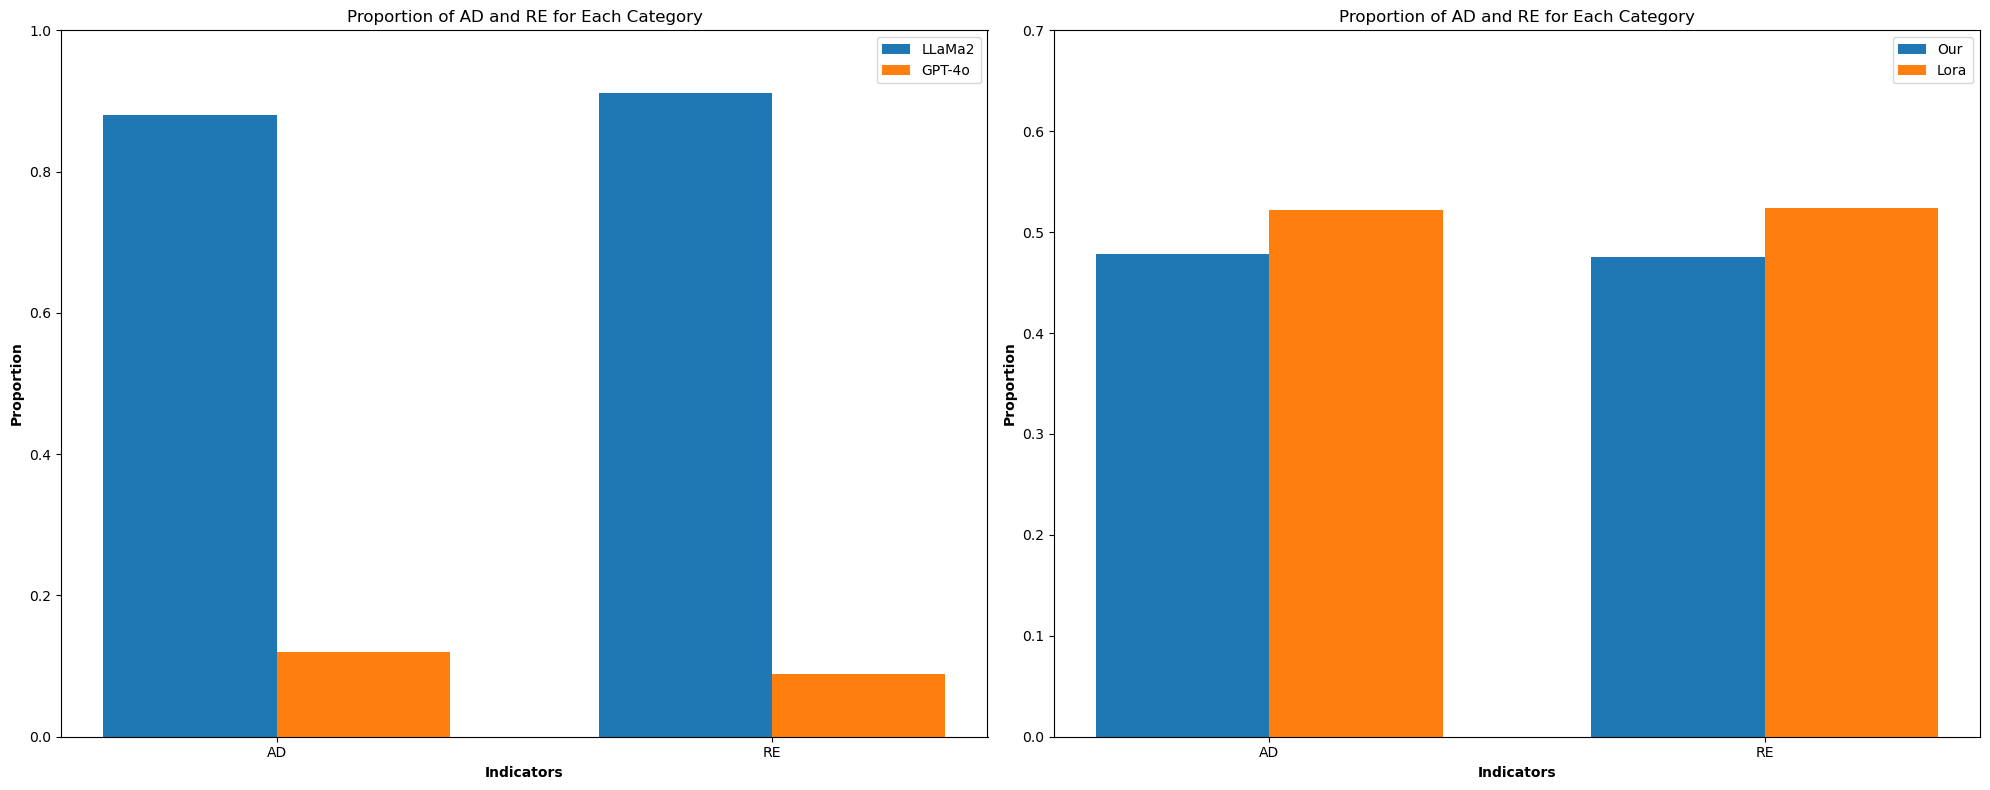

In [80]:
def plot_metrics(df, ax, our_label='Our', else_label='Else', ylim = 1.0):
    df['AD_ratio_our'] = df['our_AD'] / (df['our_AD'] + df['else_AD'])
    df['AD_ratio_else'] = df['else_AD'] / (df['our_AD'] + df['else_AD'])
    df['RE_ratio_our'] = df['our_RE'] / (df['our_RE'] + df['else_RE'])
    df['RE_ratio_else'] = df['else_RE'] / (df['our_RE'] + df['else_RE'])

    indicators = ['AD_ratio', 'RE_ratio']
    our_ratios = [df['AD_ratio_our'].values[0], df['RE_ratio_our'].values[0]]
    else_ratios = [df['AD_ratio_else'].values[0], df['RE_ratio_else'].values[0]]

    bar_width = 0.35
    positions = list(range(len(indicators)))

    ax.bar([p - bar_width/2 for p in positions], our_ratios, width=bar_width, label=our_label)
    ax.bar([p + bar_width/2 for p in positions], else_ratios, width=bar_width, label=else_label)

    ax.set_xlabel('Indicators', fontweight='bold')
    ax.set_ylabel('Proportion', fontweight='bold')
    ax.set_title('Proportion of AD and RE for Each Category')

    ax.set_xticks(positions)
    ax.set_xticklabels(['AD', 'RE'])
    ax.set_ylim(0, ylim)
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plot_metrics(df1, axs[0], our_label='LLaMa2', else_label='GPT-4o', ylim=1.0)

plot_metrics(df2, axs[1], our_label='Our', else_label='Lora', ylim=0.7)

plt.tight_layout()
plt.show()